In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Read in the data from csv
human_data = pd.read_csv('human data/reading speed decrement.csv')
simulated_data = pd.read_csv('0627_perturbation_fine_grid_search_results.csv')

# Filter simulated_data for dwell steps=0.2
simulated_data = simulated_data[
    (simulated_data['dwell_steps'] == 0.2)
    & (simulated_data['perturbation_amp_noise_scale'] == 0.01)
]

In [2]:
%%time

def compute_cost(sim_ratio, human_ratio_mean):
    return np.abs(sim_ratio - human_ratio_mean)

# Lists to store results
results_list = []

num_iterations = 500  # 12 choose 6

for i in range(num_iterations):
    # 2. Split human data into train and test
    train, test = train_test_split(human_data, test_size=6, random_state=i)
    
    train_mean_ratio = np.mean(train['ratio'])
    test_mean_ratio = np.mean(test['ratio'])
    
    min_cost = float('inf')
    best_params = None
    sim_mean_ratio = None

    # 3. Find the closest match
    for index, row in simulated_data.iterrows():
        cost = compute_cost(row['walk_over_stand_percent'], train_mean_ratio)
        if cost < min_cost:
            min_cost = cost
            best_params = row
            sim_mean_ratio = row['walk_over_stand_percent']
            
    results_list.append({
        'perturbation_amp_tuning_factor': best_params['perturbation_amp_tuning_factor'],
        'perturbation_amp_noise_scale': best_params['perturbation_amp_noise_scale'],
        'train_mean_ratio': train_mean_ratio,
        'test_mean_ratio': test_mean_ratio,
        'sim_mean_ratio': sim_mean_ratio
    })

# Storing and displaying results
results = pd.DataFrame(results_list)
# print(results)


CPU times: total: 1.06 s
Wall time: 1.28 s


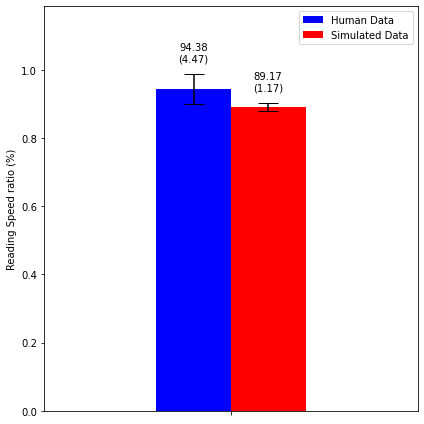

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Given labels
labels = ['Walking Reading Speed vs Standing Reading Speed']
labels = []

# Calculate SEM
def std(data):
    return np.std(data) #/ np.sqrt(len(data))

# Extract means and SEM for the test and simulation data
mean_test_ratio = np.mean(results['test_mean_ratio'])
std_test_ratio = std(results['test_mean_ratio'])
mean_simulated_ratio = np.mean(results['sim_mean_ratio'])
std_simulated_ratio = std(results['sim_mean_ratio'])

# Plotting
x = np.array([0.5])  # set the x location to 0.5, so it's centered
width = 0.2  # bar width

fig, ax = plt.subplots(figsize=(6, 6))
fig.subplots_adjust(left=0.4, right=0.6, top=0.9, bottom=0.2)  # Adjust white space margins

rects1 = ax.bar(x - width/2, mean_test_ratio, width, label='Human Data', color='blue', yerr=std_test_ratio, capsize=10)
rects2 = ax.bar(x + width/2, mean_simulated_ratio, width, label='Simulated Data', color='red', yerr=std_simulated_ratio, capsize=10)

# Annotating bars with mean and SEM values
for rects, mean_val, std_val in [(rects1, mean_test_ratio, std_test_ratio), (rects2, mean_simulated_ratio, std_simulated_ratio)]:
    rect = rects[0]
    height = rect.get_height()
    
    # Annotate with mean value
    ax.annotate(f'{mean_val*100:.2f}\n({std_val*100:.2f})',
                xy=(rect.get_x() + rect.get_width() / 2, height + std_val + 0.02),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Labels, title, and custom x-axis tick labels
ax.set_ylabel('Reading Speed ratio (%)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adjust y-axis limit
y_max = max(mean_test_ratio + std_test_ratio, mean_simulated_ratio + std_simulated_ratio)
ax.set_ylim(0, y_max * 1.2)  # Adding a bit of margin to the top
ax.set_xlim(0, 1)

fig.tight_layout()
plt.show()


In [4]:
# RMSE
# Compute RMSE function
def compute_rmse(true_vals, predicted_vals):
    return np.sqrt(np.mean((np.array(true_vals) - np.array(predicted_vals)) ** 2))

# Calculate RMSE between test and simulated data
rmse = compute_rmse(results['test_mean_ratio']*100, results['sim_mean_ratio']*100)
print(f"Root Mean Square Error (RMSE) between test and simulated data: {rmse:.4f}")

Root Mean Square Error (RMSE) between test and simulated data: 7.2528
